# Classical Job Shop Scheduling
## Feasible Gantt Chart for 2-Job, 3-Machine JSSP

This notebook demonstrates a basic example of a **Job Shop Scheduling Problem (JSSP)** with:
- **2 Jobs**, each consisting of **3 operations**
- **3 Machines**: M1, M2, M3
- The objective is to visualize a **feasible schedule** where all constraints are satisfied.

We will use **Gantt charts** to represent the schedule visually.

### Problem Definition

**Job 1:**
- Operation 1 on Machine M1 for 1 unit
- Operation 2 on Machine M2 for 2 units
- Operation 3 on Machine M3 for 1 unit

**Job 2:**
- Operation 1 on Machine M2 for 2 units
- Operation 2 on Machine M3 for 1 unit
- Operation 3 on Machine M1 for 2 units

The goal is to respect the **processing order**, avoid **machine conflicts**, and **minimize the makespan** (i.e., the total time to finish all jobs).

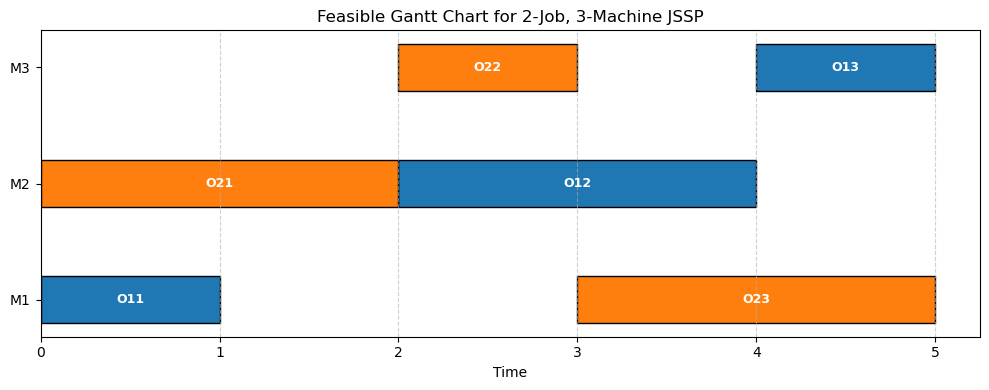

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the JSSP schedule: (Job ID, Task ID, Machine, Start Time, Duration)
schedule = [
    ("Job 1", "O11", "M1", 0, 1),
    ("Job 1", "O12", "M2", 2, 2),
    ("Job 1", "O13", "M3", 4, 1),
    ("Job 2", "O21", "M2", 0, 2),
    ("Job 2", "O22", "M3", 2, 1),
    ("Job 2", "O23", "M1", 3, 2),
]

#Convert to Data
df = pd.DataFrame(schedule, columns=["Job", "Task", "Machine", "Start", "Duration"])

#colors by job
colors = {"Job 1": "tab:blue", "Job 2": "tab:orange"}

fig, ax = plt.subplots(figsize=(10, 4))

# Machines on y-axis
machines = sorted(df["Machine"].unique())
machine_pos = {machine: i for i, machine in enumerate(machines)}

for _, row in df.iterrows():
    ax.barh(
        y=machine_pos[row["Machine"]],
        width=row["Duration"],
        left=row["Start"],
        height=0.4,
        color=colors[row["Job"]],
        edgecolor="black"
    )
    ax.text(
        row["Start"] + row["Duration"] / 2,
        machine_pos[row["Machine"]],
        row["Task"],
        va="center",
        ha="center",
        color="white",
        fontsize=9,
        fontweight="bold"
    )
ax.set_yticks(list(machine_pos.values()))
ax.set_yticklabels(list(machine_pos.keys()))
ax.set_xlabel("Time")
ax.set_title("Feasible Gantt Chart for 2-Job, 3-Machine JSSP")
ax.grid(True, axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### Key Observations

- No machine is used by more than one job at the same time.
- Operations within each job follow the required order.
- The **makespan** (total completion time) is 5 time units.
- This is a **feasible** schedule, but it may not be optimal.

This example forms a good basis to construct a **QUBO formulation**, where:
- Each variable encodes task start times
- Constraints are added as penalties
- The objective is to minimize makespan (or other cost functions)



# Job Shop Scheduling as QUBO (Quantum Optimization)
In this example, we formulate a small JSSP as a QUBO and prepare it for use with QAOA.
We define binary variables $x_{k,t}$ which indicate whether task $k$ starts at time $t$.

The cost function consists of three penalty terms:
- h1: Each task starts exactly once
- h2: No two tasks on the same machine overlap
- h3: Tasks in a job must follow a specified order

## Problem Setup

In [2]:
import itertools
import numpy as np

In [3]:
# Task definitions: each task = (job_id, task_id, machine_id, processing_time)
tasks = [
    (0, 0, 0, 2),
    (0, 1, 1, 3),
    (1, 0, 1, 2),
    (1, 1, 0, 1)
]

T_max = 5  # Time horizon
num_tasks = len(tasks)

# Map task indices to task info
task_map = {k: tasks[k] for k in range(num_tasks)}

## Binary Variables $x_{k,t}$
We introduce binary variables for each task `k` at each time step `t`

In [4]:
x_vars = list(itertools.product(range(num_tasks), range(T_max)))
x_index = { (k, t): i for i, (k, t) in enumerate(x_vars) }
num_vars = len(x_vars)

## QUBO Construction
We construct a QUBO matrix `Q` for the expression: $H_C(x) = \lambda_1 h_1(x) + \lambda_2 h_2(x) + \lambda_3 h_3(x)$

In [5]:
# Initialization of the matrix and the constants:
Q = np.zeros((num_vars, num_vars))

lambda_1 = 5.0  # Unique start
lambda_2 = 5.0  # No machine overlap
lambda_3 = 5.0  # Task order

The constraints are implemented in the python file helper.py. You can look up the implementation there. Try to understand the implementation of the constraints.

### h1: Unique start constraint

$$ h_1(x) = \sum_k \left(\sum_t x_{k,t} - 1 \right)^2 = \sum_k \left(\sum_t x_{k,t}^2  + \sum_{t\neq t'} x_{k,t} x_{k,t'} -2\sum_t x_{k,t} +1 \right) $$
And $\sum_t x_{k,t}^2 = \sum_t x_{k,t}$ because $x_{k,t}$ is binary 
$$\Rightarrow  \sum_k \left(\sum_t x_{k,t}^2 -2\sum_t x_{k,t} + \sum_{t\neq t'} x_{k,t} x_{k,t'} +1 \right) = \sum_k \left(-\sum_t x_{k,t} + \sum_{t\neq t'} x_{k,t} x_{k,t'} +1 \right)$$

In [6]:
from helper import apply_unique_start_constraint

Q = apply_unique_start_constraint(Q, x_index, num_tasks, T_max, penalty=lambda_1)

### h2: Machine conflict constraint

$$ h_2(x) = \sum_m \left(\sum_{\substack{k \neq k' \\ 0 \leq t, t' \leq T \\ 0 < t' -t < \ell_k}}  x_{k,t} x_{k',t'} \right) $$

In [7]:
from helper import apply_machine_conflict_constraint

Q = apply_machine_conflict_constraint(Q, x_index, task_map, T_max, penalty=lambda_2)

### h3: Task order within each job

$$ h_3(x) = \sum_{n=1}^J \left(\sum_{\substack{k_{n-1}<k<k_n \\ t+\ell_k > t'}} x_{k,t} x_{k+1,t'}\right) $$

In [8]:
from helper import apply_precedence_constraint

Q = apply_precedence_constraint(Q, x_index, task_map, T_max, penalty=lambda_3)

## Result: QUBO Matrix Ready for Quantum Optimization
The matrix `Q` can now be used with QAOA (via Qiskit, for example), or classical solvers. Here is a visualization of the QUBO matrix.

In [9]:
import pandas as pd

qubo_df = pd.DataFrame(Q)
qubo_df.round(1).style.background_gradient(cmap="coolwarm")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000
1,0.000000,-5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000
2,0.000000,0.000000,-5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
3,0.000000,0.000000,0.000000,-5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
4,0.000000,0.000000,0.000000,0.000000,-5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,5.000000,5.000000,5.000000,5.000000,0.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,5.000000,5.000000,5.000000,0.000000,0.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Classical vs Quantum Perspective
The current notebook generates the **QUBO formulation of the Job Shop Scheduling Problem (JSSP)** using classical computing. 
It constructs a QUBO matrix using binary variables $x_{k,t}$ and encodes constraints as quadratic penalties.

While everything here is done classically (NumPy, Python), the final QUBO matrix is **quantum-ready**:
- It can be used in **QAOA** (Quantum Approximate Optimization Algorithm) via Qiskit
- Or submitted to a **quantum annealer** such as D-Wave

This is the essential first step in solving combinatorial optimization problems with quantum algorithms.


# Solving Job Shop Scheduling as QUBO with Qiskit

To solve the Job Shop Scheduling Problem (JSSP) with quantum algorithms, we first express the problem as a **Quadratic Unconstrained Binary Optimization (QUBO)** problem:

A QUBO problem is defined by an objective function of the form:

$$
C(x) = x^T Q x
$$

Where:
- $x$ is a binary vector,
- $Q$ is a symmetric matrix encoding quadratic and linear penalties.

For JSSP, we have constructed $Q$ from:
- **h₁**: Unique start time constraint for each task.
- **h₂**: No-overlap constraint on machines.
- **h₃**: Precedence constraints within jobs.

The QUBO matrix $Q$ has to be transformed to a `QuadraticProgram` so that it can be interpreted by the optimizer. Then one can solve the problem with QAOA.

In [10]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.minimum_eigensolvers import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_aer.primitives import Sampler as AerSampler

In [11]:
# Set global random seed
algorithm_globals.random_seed = 42

# Task definition: (job_id, task_idx_in_job, machine_id, duration)
tasks = [
    (0, 0, 0, 2),
    (0, 1, 1, 3),
    (1, 0, 1, 2),
    (1, 1, 0, 1)
]

T_max = 5 # Maximal time
num_tasks = len(tasks)
task_map = {k: tasks[k] for k in range(num_tasks)}


Define variables:

In [12]:
x_vars = list(itertools.product(range(num_tasks), range(T_max)))
x_index = { (k, t): i for i, (k, t) in enumerate(x_vars) }
num_vars = len(x_vars)

Construct the QUBO matrix:

In [13]:
Q = np.zeros((num_vars, num_vars))

lamb_1 = 10.0
Q = apply_unique_start_constraint(Q, x_index, num_tasks, T_max, penalty=lambda_1)

lamb_2 = 10.0
Q = apply_machine_conflict_constraint(Q, x_index, task_map, T_max, penalty=lambda_2)

lamb_3 = 10.0
Q = apply_precedence_constraint(Q, x_index, task_map, T_max, penalty=lambda_3)

Introduce the makespan objective into the QUBO matrix by introducing it as a late-finish penalty. The function is implemented in helper.py.

In [14]:
from helper import apply_makespan_objective

makespan_weight = 1.0
Q = apply_makespan_objective(Q, x_index, task_map, num_tasks, T_max, weight=makespan_weight)

Convert the QUBO matrix into a `QuadraticProgram`: 

In [15]:
qp = QuadraticProgram()
for i in range(num_vars):
    qp.binary_var(name=f"x_{i}")

# Fill in linear and quadratic terms:
linear = {f"x_{i}": Q[i, i] for i in range(num_vars)}
quadratic = {
    (f"x_{i}", f"x_{j}"): Q[i, j]
    for i in range(num_vars) for j in range(i + 1, num_vars) if Q[i, j] != 0}
        
qp.minimize(linear=linear, quadratic=quadratic)

Now we can solve the problem with QAOA.

In [16]:
# QAOA pipeline:
sampler = AerSampler(backend_options={"method": "statevector"})
qaoa = QAOA(sampler=sampler, optimizer=COBYLA(), reps=1)
optimizer = MinimumEigenOptimizer(min_eigen_solver=qaoa)

# Solve the problem:
result = optimizer.solve(qp)
print("Optimal binary solution:", result.x)


Optimal binary solution: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### Visualization of the result

Now that we got our solution, we want to analyze it. So we plot a Gantt chart and check if the proposed schedule violates any of the constraints.

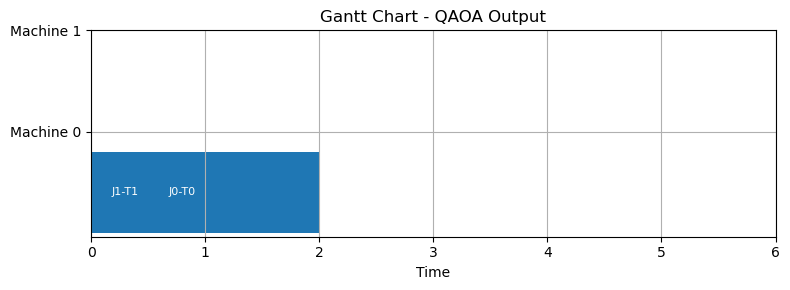

Makespan: 2
Machine conflicts:
  - {'task': 0, 'job': 0, 'task_idx': 0, 'machine': 0, 'start': 0, 'duration': 2, 'end': 2} overlaps with {'task': 3, 'job': 1, 'task_idx': 1, 'machine': 0, 'start': 0, 'duration': 1, 'end': 1}
Unique start violations:
Task 2 starts 0 times.
Task 3 starts 0 times.


In [17]:
from helper import extract_schedule_from_result, plot_gantt_chart_machines, compute_makespan, check_machine_conflicts, check_precedence_violations, check_unique_start_constraint

schedule = extract_schedule_from_result(result.x, x_index, task_map, num_tasks, T_max)
plot_gantt_chart_machines(schedule, T_max, title="Gantt Chart - QAOA Output")

# Analyze:
print("Makespan:", compute_makespan(schedule))
machine_conflicts = check_machine_conflicts(schedule)
precedence_violations = check_precedence_violations(schedule)
unique_start_violations = check_unique_start_constraint(schedule, num_tasks)

if machine_conflicts:
    print("Machine conflicts:")
    for a, b in machine_conflicts:
        print(f"  - {a} overlaps with {b}")

if precedence_violations:
    print("Precedence violations:")
    for a, b in precedence_violations:
        print(f"  - {a} finishes after {b} starts")

if unique_start_violations:
    print("Unique start violations:")
    for task_id, count in unique_start_violations:
        print(f"Task {task_id+1} starts {count} times.")
    

if not machine_conflicts and not precedence_violations and not unique_start_violations:
    print("No constraint violations detected.")


# Let's play around

Now we want to inspect different penalty constansts and see how the schedule changes.

In [18]:
# Set seed for reproducibility
algorithm_globals.random_seed = 42

# Task definition: (job_id, task_idx_in_job, machine_id, duration)
tasks = [
    (0, 0, 0, 2),
    (0, 1, 1, 3),
    (1, 0, 1, 2),
    (1, 1, 0, 1)]

T_max = 5
num_tasks = len(tasks)
task_map = {i: tasks[i] for i in range(num_tasks)}
x_index = {(i, t): i * T_max + t for i in range(num_tasks) for t in range(T_max)}
num_vars = num_tasks * T_max


In [19]:
 # === Penalty Configurations ===
penalty_sets = [
    {
        "name": "Baseline",
        "one_hot": 10.0,
        "machine": 10.0,
        "precedence": 10.0,
        "makespan": 1.0
    },
    {
        "name": "Makespan-focused",
        "one_hot": 10.0,
        "machine": 5.0,
        "precedence": 5.0,
        "makespan": 5.0
    },
    {
        "name": "Relaxed constraints",
        "one_hot": 10.0,
        "machine": 1.0,
        "precedence": 1.0,
        "makespan": 0.5
    }
]

To solve the JSSP for the different penalty configurations,  a function is implemented in helper.py to solve the problem with QAOA and visualize the schedule.

/local/u15233_8756807/ipykernel_1410178/1539390156.py:5: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  solve_and_visualize_jssp(penalty_config, num_vars, x_index, task_map, num_tasks, T_max, colors)



* Penalty Config: Baseline
  - Binary Solution: [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]


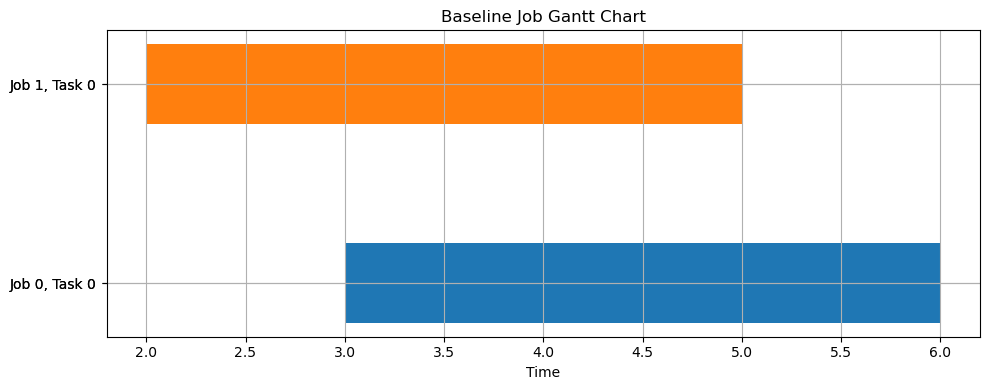

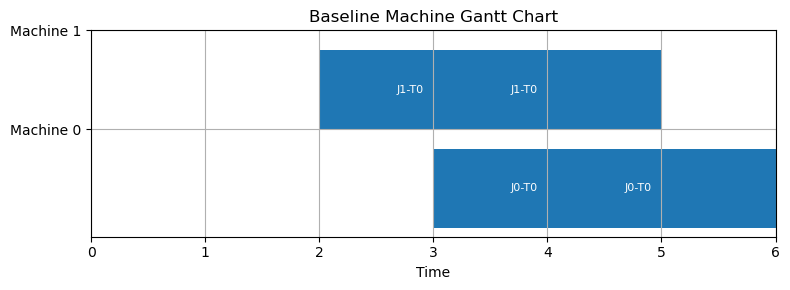

/local/u15233_8756807/ipykernel_1410178/1539390156.py:5: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  solve_and_visualize_jssp(penalty_config, num_vars, x_index, task_map, num_tasks, T_max, colors)



* Penalty Config: Makespan-focused
  - Binary Solution: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


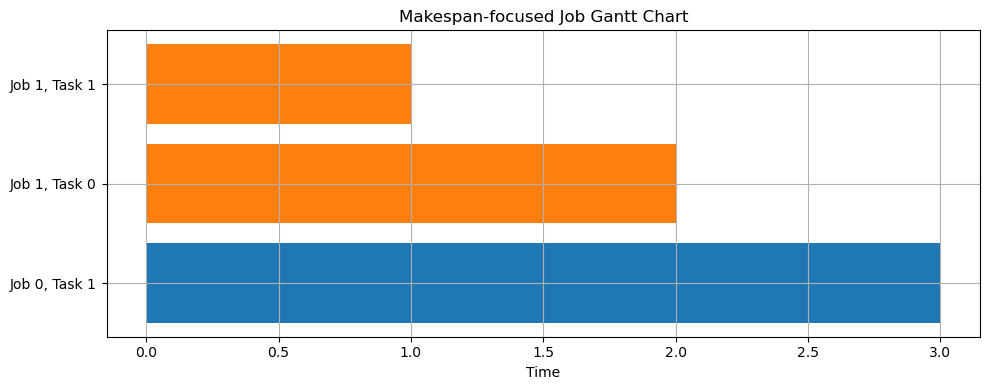

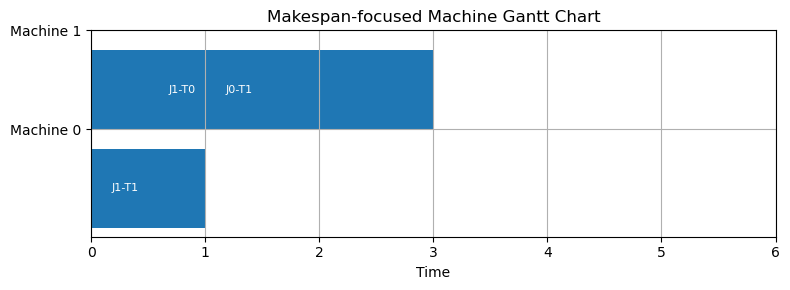

/local/u15233_8756807/ipykernel_1410178/1539390156.py:5: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  solve_and_visualize_jssp(penalty_config, num_vars, x_index, task_map, num_tasks, T_max, colors)



* Penalty Config: Relaxed constraints
  - Binary Solution: [1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]


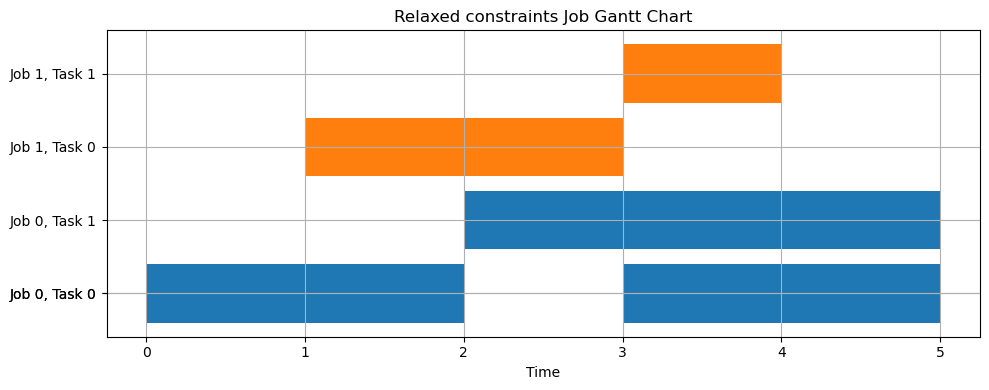

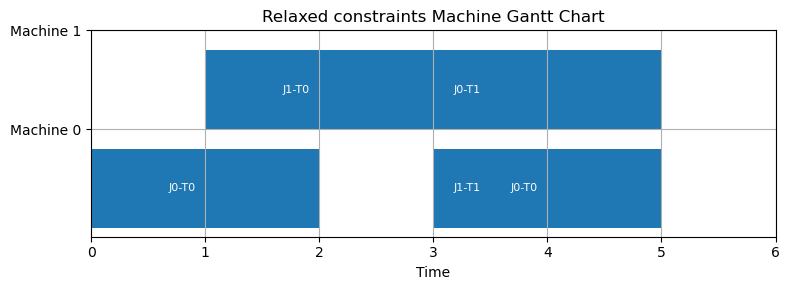

In [20]:
from helper import solve_and_visualize_jssp

colors = ["tab:blue", "tab:orange"]
for penalty_config in penalty_sets:
    solve_and_visualize_jssp(penalty_config, num_vars, x_index, task_map, num_tasks, T_max, colors)

## Analysis & Comments on Each Penalty Set

### 1. Baseline

Penalties: All constraints strongly enforced (10.0), modest makespan weight (1.0).

- Feasible solution: no overlaps, task precedence respected.
  
Interpretation: A balanced schedule that respects all constraints but does not aggressively minimize makespan.

### 2. Makespan-focused

Penalties: Medium conflict/precedence penalties (5.0), high makespan penalty (5.0).
- Also feasible: all constraints satisfied.

Interpretation: The optimizer pushed for an earlier finish while still maintaining feasibility — better throughput, slightly tighter schedule.

### 3. Relaxed constraints

Penalties: Soft machine and precedence penalties (1.0), very low makespan weight (0.5).
- Infeasible schedule:

Interpretation: Low penalties make constraint violations "cheap", so QAOA ignores some to reduce cost.

### You’ll likely notice:

Higher makespan penalty gives you faster schedules — but maybe at the cost of overlapping machines or broken task orders if those penalties are low.

Lower conflict or precedence penalties allow violations, demonstrating their role as soft constraints.

# Try it yoursef

Now you can play around a little bit with different penalty constants. Maybe you can find an optimal schedule. You can use the functions from helper.py. 

In [ ]:
penalty_constants = {"name": "Try it yourself",
                     "one_hot": ...,
                     "machine": ...,
                     "precedence": ...,
                     "makespan": ...
                    }

Definition of the schedule:

In [ ]:
# Set seed for reproducibility
algorithm_globals.random_seed = 42

# Task definition: (job_id, task_idx_in_job, machine_id, duration)
tasks = [
    (0, 0, 0, 2),
    (0, 1, 1, 3),
    (1, 0, 1, 2),
    (1, 1, 0, 1)]

T_max = 5
num_tasks = len(tasks)
task_map = {i: tasks[i] for i in range(num_tasks)}
x_index = {(i, t): i * T_max + t for i in range(num_tasks) for t in range(T_max)}
num_vars = num_tasks * T_max

Solve the schedule here:

In [ ]:
#TODO 